In [1]:
from pydoc import importfile
import rdflib
import random
import pandas as pd
from sklearn.cluster import KMeans

from rdflib import ConjunctiveGraph
import gc, copy, datetime

import os, sys
p = os.path.abspath('..')
sys.path.insert(1, p)

from knowledge_graph import *

from rdf2vec import RDF2VecTransformer

from lcs_rdf_graph_test import LCS

from rdf_graph_utils import rdf_to_plot, rdf_to_text


def rdflib_to_kg_nquads(rdflib_g, label_predicates=[]):
    # Iterate over quads, add s, p and o to graph and 2 edges (s-->p, p-->o)
    # all predicates in label_predicates get excluded
    print(rdflib_g)
    kg = KnowledgeGraph()
    for s, p, o, _ in rdflib_g.quads((None, None, None, None)):
        if p not in label_predicates:
            s_v, o_v = Vertex(str(s)), Vertex(str(o))
            p_v = Vertex(str(p), predicate=True)
            kg.add_vertex(s_v)
            kg.add_vertex(p_v)
            kg.add_vertex(o_v)
            kg.add_edge(s_v, p_v)
            kg.add_edge(p_v, o_v)

    return kg


def get_drug_name(graph, drug):
    query = """
               SELECT ?obj
               WHERE { ?s <http://www.w3.org/2000/01/rdf-schema#label> ?obj.
               """.replace("?s", "<%s>" % drug) + "}"

    query_res = graph.query(query)
    label = []
    for res in query_res:
        label.append(str(res.obj))

    return label


In [2]:
print(end='Loading data... ', flush=True)
g = ConjunctiveGraph()

g.parse('../../datasets/drugbank/drugbank.nq', format="nquads")
print('OK')
#
# # Extract all database drugs' URI
all_drugs_file = pd.read_csv('../../datasets/drugbank/all_drugs.tsv', sep='\t')
all_drugs = [rdflib.URIRef(x) for x in all_drugs_file['drug']]
#
# # Define irrelevant predicates
predicates = pd.read_csv('../../datasets/drugbank/bad_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates['predicate']]
#

stop_patterns = pd.read_csv('../../datasets/drugbank/stop_patterns.tsv', sep='\t')
stop_patterns = [x for x in stop_patterns['stopping_patterns']]

preds = pd.read_csv('../../datasets/drugbank/uninformative.tsv', sep='\t')
preds = [rdflib.URIRef(x) for x in preds['uninformative']]


Loading data... OK


In [3]:
kg = rdflib_to_kg_nquads(g, label_predicates=predicates)

#del g
#gc.collect()

#
# # %%
# # estraggo un'istanza di knowledge graph per ogni drug presente in quello iniziale

kg_depth = 4

i = 0
j = 0

kv = []
drugs = []
graphs = []

for drug in all_drugs:
    try:
        gi = extract_instance(kg, drug, kg_depth)
        graphs.append(gi)
        drugs.append(drug)
        kv.append({'graph': gi, 'resource': drug})
        i += 1
    except Exception as e:
        j += 1

print('ok:' + str(i))
print('not imported: ' + str(j))

del kg
gc.collect()


[a rdflib:ConjunctiveGraph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']]
ok:7754
not imported: 5


0

In [4]:
# # Embeddings
transformer = RDF2VecTransformer(wl=False, max_path_depth=4, vector_size=15, walks_per_graph=1)
# transformer = RDF2VecTransformer()
transformer.fit(graphs, drugs)
embeddings = transformer.transform(graphs, drugs)



7754it [00:05, 1546.97it/s]


Extracted 7754 walks for 7754 instances!
Starting Word2Vec Model
Word2Vec Ended
Transform.


In [5]:
# STAMPO PER OGNI RISORSA IL CLUSTER A CUI CORRISPONDE, IN MODO DA POTERNE PRELEVARE PER IL MOMENTO
# DUE APPARTENENTI ALLO STESSO CLUSTER
kmeans = KMeans(n_clusters=250)
km = kmeans.fit(embeddings)
y_kmeans = kmeans.predict(embeddings)

print("clustering models created")

clustering models created


In [6]:

clusters = {i: [] for i in range(kmeans.n_clusters)}
i = 0
for j in y_kmeans:
    clusters[j].append(i)
    i += 1

# Save clusters obtained from kmeans
file = open("../../datasets/drugbank/clusters_log/kmeans_125_" + str(datetime.datetime.now()).replace(":", "."), "a")
file.write(str(clusters))
file.close()


In [7]:
# Print clusters and their dimension

for key in clusters.keys():
    print("cluster " + str(key) + " with dimension: " + str(len(clusters[key])))


cluster 0 with dimension: 14
cluster 1 with dimension: 29
cluster 2 with dimension: 12
cluster 3 with dimension: 44
cluster 4 with dimension: 30
cluster 5 with dimension: 38
cluster 6 with dimension: 31
cluster 7 with dimension: 33
cluster 8 with dimension: 31
cluster 9 with dimension: 22
cluster 10 with dimension: 34
cluster 11 with dimension: 41
cluster 12 with dimension: 22
cluster 13 with dimension: 16
cluster 14 with dimension: 34
cluster 15 with dimension: 31
cluster 16 with dimension: 34
cluster 17 with dimension: 30
cluster 18 with dimension: 32
cluster 19 with dimension: 7
cluster 20 with dimension: 25
cluster 21 with dimension: 13
cluster 22 with dimension: 37
cluster 23 with dimension: 33
cluster 24 with dimension: 33
cluster 25 with dimension: 33
cluster 26 with dimension: 25
cluster 27 with dimension: 39
cluster 28 with dimension: 26
cluster 29 with dimension: 39
cluster 30 with dimension: 24
cluster 31 with dimension: 31
cluster 32 with dimension: 42
cluster 33 with dimen

In [8]:
directory = "../../outputs/drugbank/oLast_NQ_NEW_optimized_" + str(datetime.datetime.now()).replace(":", ".").replace(" ", "_")
if not os.path.exists(directory):
    os.mkdir(directory)


# cluster da analizzare
# k = 22

# seleziono il cluster con il minor numero di elementi
k = min(clusters.keys(), key=lambda a: len(clusters[a]))

# seleziono il cluster con il minor numero totale di archi
# k = min(clusters.keys(), 
#        key=lambda key: sum(len(kg_to_rdflib(graphs[res], kg_depth)) for res in clusters[key]))

# seleziono il cluster con l'elemento che ha il minor numero di archi
# k = min(clusters.keys(), key=lambda key: min([len(kg_to_rdflib(graphs[res], kg_depth))
#                                                 for res in clusters[key]]))


clusters[k] = sorted(clusters[k],  key=lambda res: len(kg_to_rdflib(graphs[res], kg_depth)))

# clusters[k] = [48, 50]

L = len(clusters[k])

print("esploro il cluster: " + str(k) + " con dimensione " + str(L))
print(clusters[k])
# risorsa iniziale
# resource_1 = random.choice(clusters[k])

resource_1 = clusters[k].pop(0)

graph_1 = graphs[resource_1]

print("risorsa iniziale: " + str(resource_1) + " di dim -> " + str(len(kg_to_rdflib(graph_1, kg_depth))))

# clusters[k].remove(resource_1)
explored_resoures = [resource_1]

iteration = 0



esploro il cluster: 19 con dimensione 7
[4679, 4960, 5687, 1155, 4096, 6279, 2495]
risorsa iniziale: 4679 di dim -> 13


In [9]:
stop = False
highcount = 0
explored_resoures_ok = [resource_1]

while (clusters[k] and stop == False):

    file = open(directory + "/tmp_LCS.log", "a")
    
    resource_2 = clusters[k].pop(0)
    graph_2 = graphs[resource_2]
    print("LCS with resource: " + str(resource_2) 
          + " con dim: " + str(len(kg_to_rdflib(graph_2, kg_depth))))
    
    # seed
    seed = LCS(graph_1, graph_2, depth=2, stop_patterns=stop_patterns, uninformative_triples=preds)
    seed.find()
             
    explored_resoures.append(resource_2)
        
    print("dim LCS itermedio tra " + str(explored_resoures) + " \n--> " + str(len(seed)))
      
    del graph_1
    del graph_2
    gc.collect()
        
    graph_1 = copy.deepcopy(seed)

    print("Iterazione: " + str(iteration) + ", trovato LCS tra: " + str(explored_resoures))
    rdf_to_text(seed, directory, "turtle", "tmp_LCS_" + str(iteration))
    rdf_to_text(seed, directory, "nt", "tmp_LCS_" + str(iteration))

    # Conto le triple trovate
    fileopencount = open(directory + "/output_tmp_LCS_" + str(iteration) + ".nt", "r")
    filecount = len(fileopencount.readlines())
    print("Count row: ", filecount)

    if iteration == 0 and filecount == 1:
      stop = True
      print("Iteration stopped at iteration: " + str(iteration))
    elif iteration == 0:
      highcount = filecount

    if filecount <= highcount and iteration != 0:
      stop = True
      print("Iteration stopped at iteration: " + str(iteration))
    else:
      highcount = filecount
      graph_ok = graph_1
      explored_resoures_ok.append(resource_2)
      file.write("Iterazione: " + str(iteration) +  " risorse esplorate: " + str(explored_resoures_ok) + "\n")
        

    fileopencount.close()
    file.close()

    del seed
    gc.collect()

    iteration += 1  


LCS with resource: 4960 con dim: 14
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [4679, 4960] 
--> 3
Iterazione: 0, trovato LCS tra: [4679, 4960]
Count row:  3
LCS with resource: 5687 con dim: 41
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [4679, 4960, 5687] 
--> 1
Iterazione: 1, trovato LCS tra: [4679, 4960, 5687]
Count row:  1
Iteration stopped at iteration: 1


#### plotting graph ####


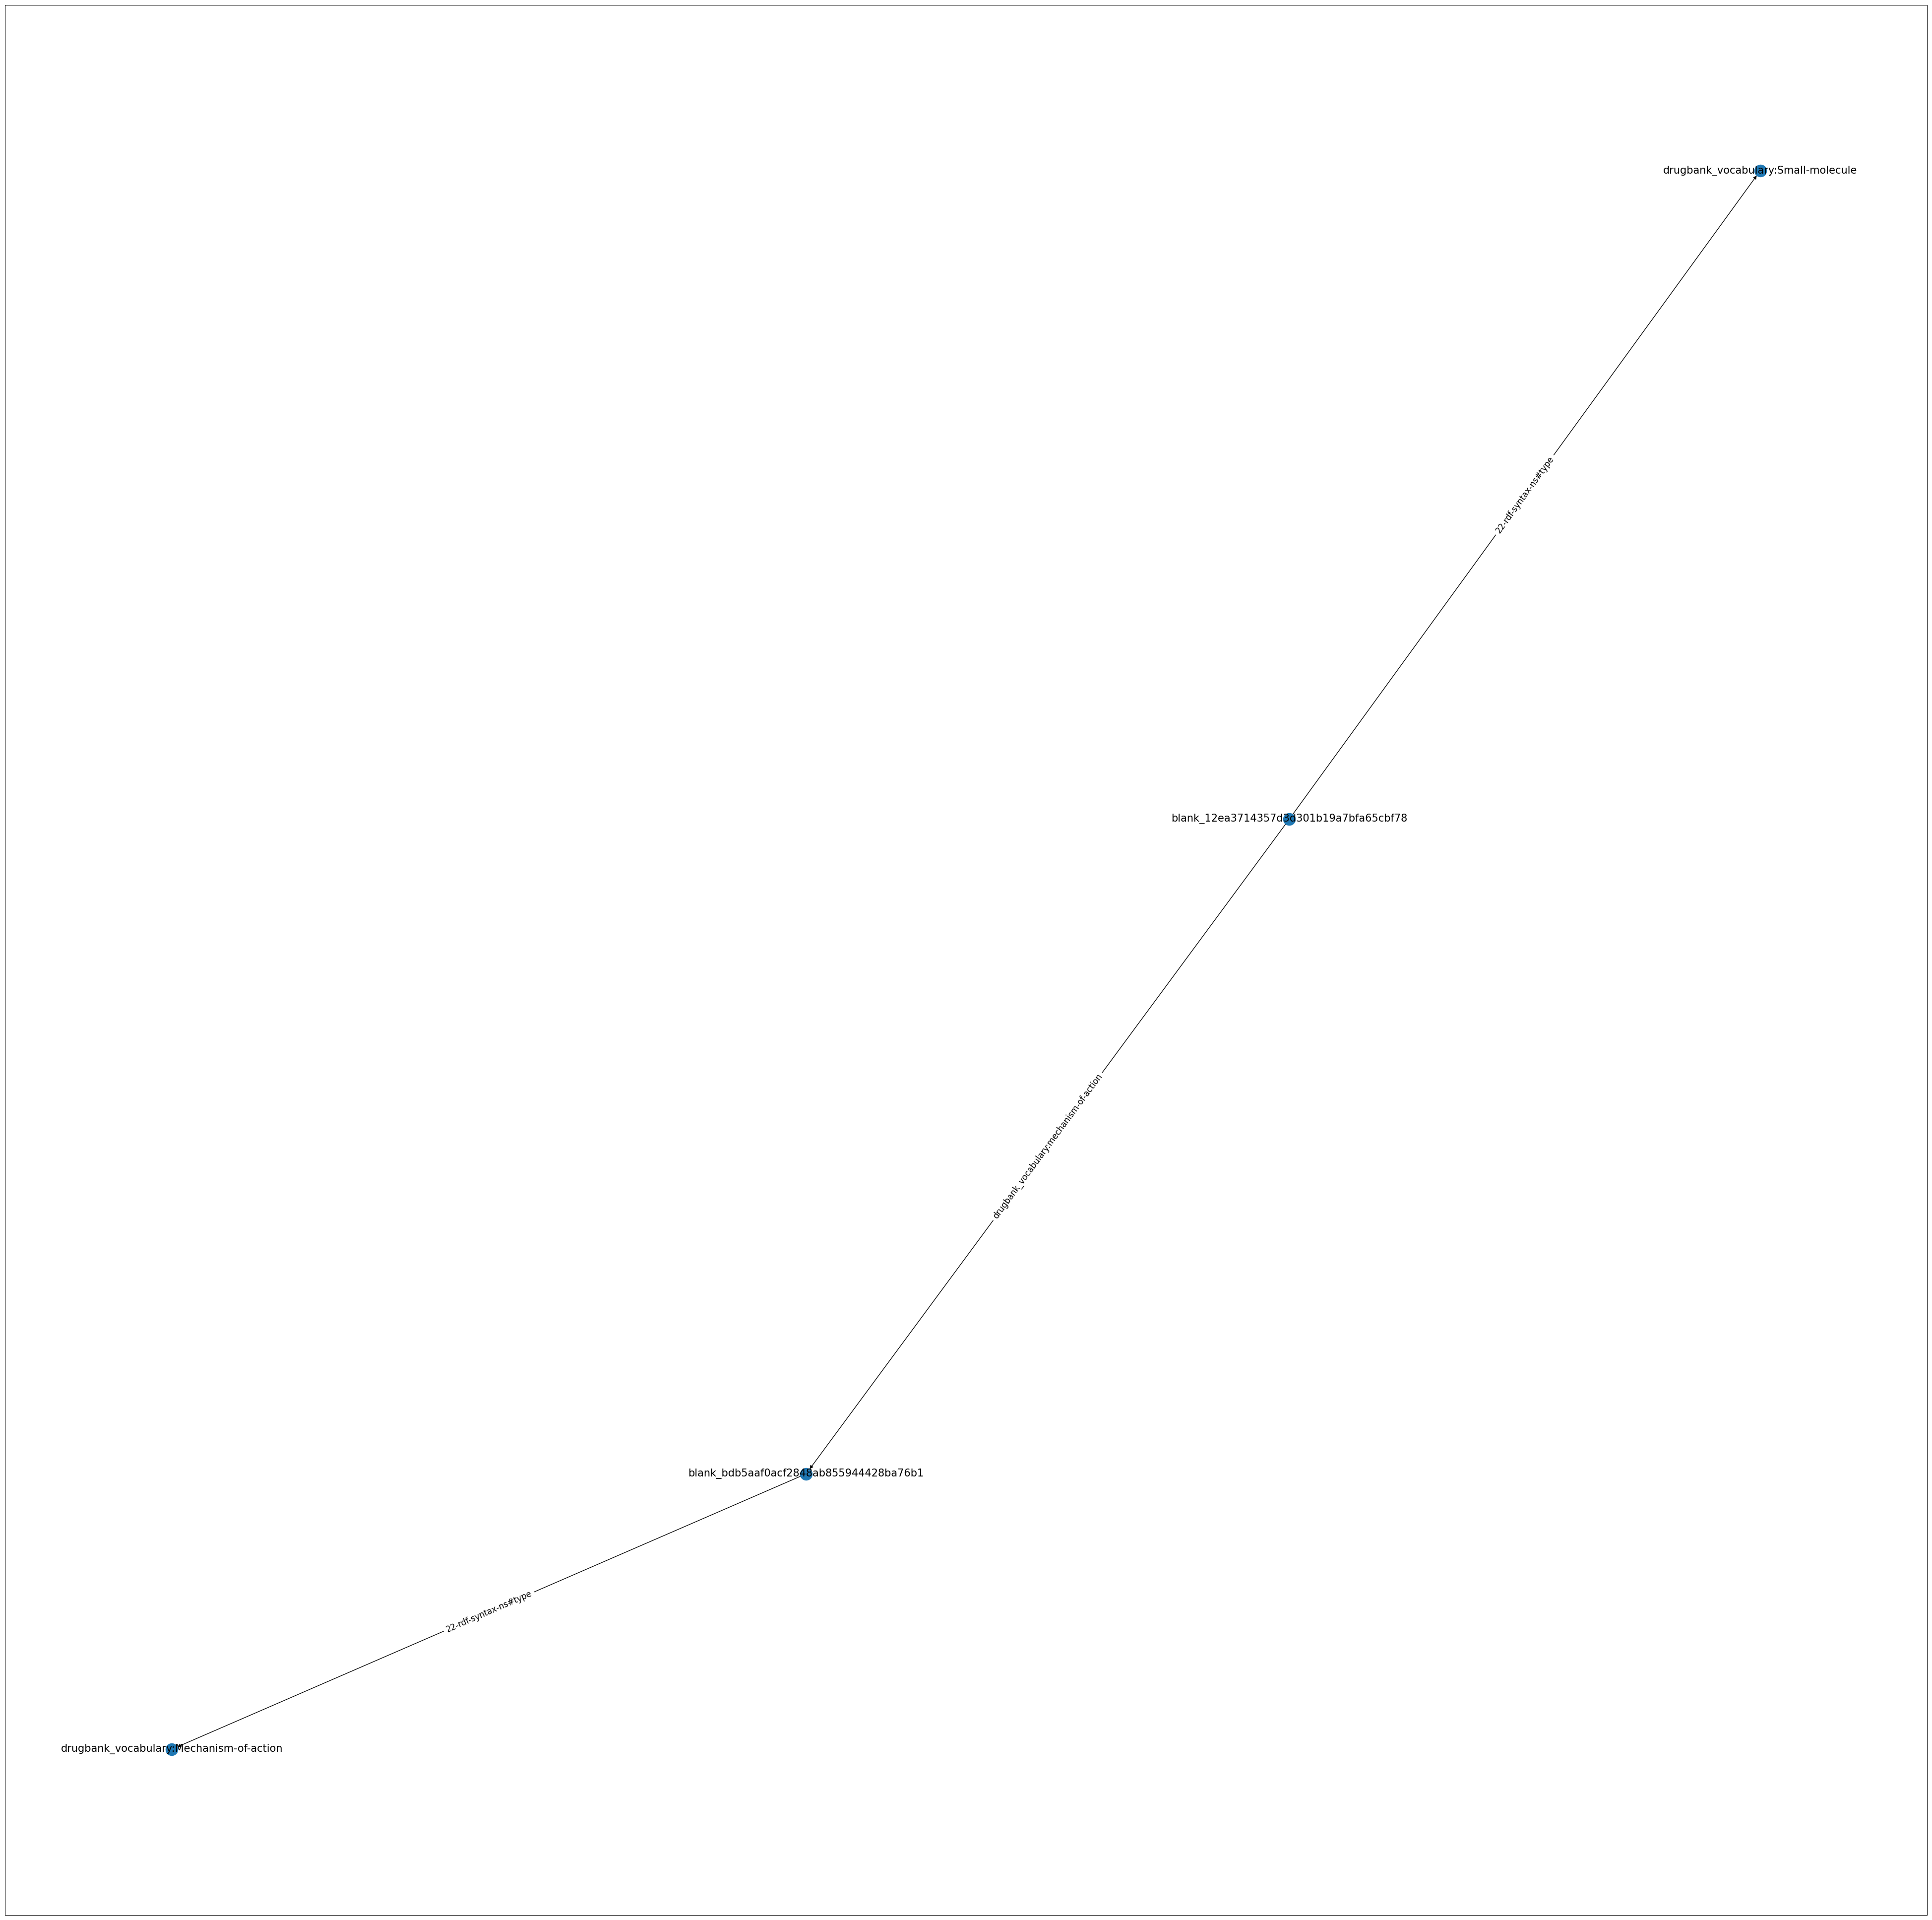

LCS finale tra le risorse: [4679, 4960]


In [10]:
iteration -= 1
if iteration > 0:
    rdf_to_plot(graph_ok, directory)
    print("LCS finale tra le risorse: " + str(explored_resoures_ok))
    file_final = open(directory + "/final_LCS_resources.log", "a")
    file_final.write(str(explored_resoures_ok))
    rdf_to_text(graph_ok, directory, 'turtle', 'final_LCS')
    rdf_to_text(graph_ok, directory, 'nt', 'final_LCS')
    plot_result = True
else:
    print("Impossible to plot")
    plot_result = False



In [11]:
if plot_result == True:
    file_final.write("\n ####### \n")

    explored_resources_names = []

    for drug_index in explored_resoures_ok:
        drug_name = get_drug_name(g, drugs[drug_index])
        explored_resources_names.extend(drug_name)

    file_final.write(str(explored_resources_names))
    file_final.close()
    del g
    gc.collect()
print('END')

END
